In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime

In [13]:
# load dataset
def parser(x):
	return datetime.strptime(x, '%Y-%m')

In [18]:
milk = pd.read_csv("milk.csv", header=0, index_col=0, parse_dates=True, date_parser=parser)
milk

,Milk
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


<AxesSubplot:xlabel='Month'>

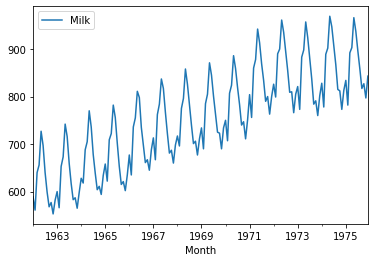

In [19]:
milk.plot()

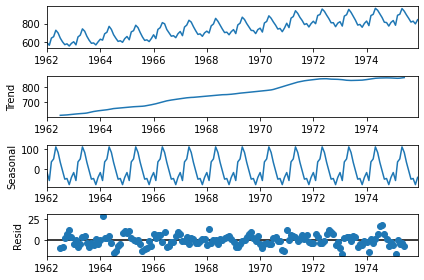

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(milk)
decomposed.plot()
plt.show()